In [26]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from math import sqrt
from sklearn.metrics import mean_squared_error
rcParams['figure.figsize'] = 30, 12
dateparse = lambda dates: pd.datetime.strptime(dates, '%d.%m.%Y')
data = pd.read_csv('your_csv_file.csv', parse_dates=["date"], index_col=["date", "item"],date_parser=dateparse)
ts = data.iloc[data.index.get_level_values('item') == "1"]
ts = ts.reset_index().set_index("date").drop(columns=["item"])

def remove_outliers(df):
    from scipy.stats import zscore
    df = df.loc[df["sold_qty"]>0]
    return df[(np.abs(zscore(df)) < 2).all(axis=1)]
def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.where((y_true<0), 0, y_true)
    y_true = np.where((y_true==0), y_true.mean(), y_true)
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def week_mean_absolute_percentage_error(y_true, y_pred):
    y_true_df = y_true.copy().to_frame()
    y_true_df["week_of_year_idx"]= pd.to_datetime(y_true_df.index).to_period('W').start_time
    y_true_df = y_true_df.groupby(['week_of_year_idx'])['sold_qty'].sum().reset_index().set_index("week_of_year_idx")
    y_true = y_true_df.sold_qty.copy()
    y_pred_df = y_pred.copy().to_frame()
    y_pred_df["week_of_year_idx"]= pd.to_datetime(y_pred_df.index).to_period('W').start_time
    y_pred_df = y_pred_df.groupby(['week_of_year_idx'])['prediction'].sum().reset_index().set_index("week_of_year_idx")
    y_pred = y_pred_df.prediction.copy()
    y_true = np.where((y_true<0), 0, y_true)
    y_true = np.where((y_true==0), y_true.mean(), y_true)
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [27]:
train = ts[:int(ts.shape[0]*0.7)]
test = ts[int(ts.shape[0]*0.7):]

train = remove_outliers(train)
test = test.loc[test["sold_qty"]>0]

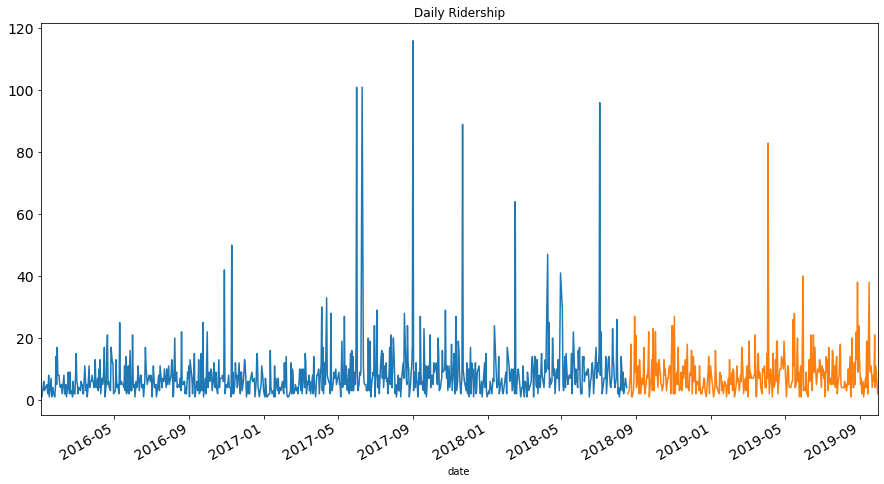

In [28]:
#Plotting data
train.sold_qty.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14)
test.sold_qty.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14)
plt.show()

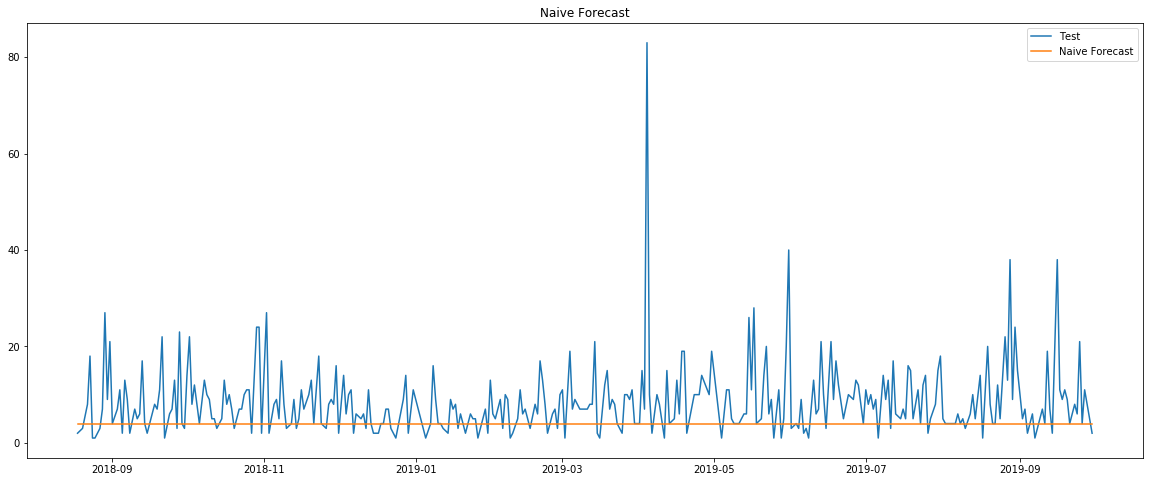

rms:8.82203566378033
mape:63.464963830686585
MAPE by week: 49.969


In [29]:
y_prediction = test.copy()
y_test=test.sold_qty
dd= np.asarray(train.sold_qty)
y_prediction["prediction"] = dd[len(dd)-1]
plt.figure(figsize=(20,8))
#plt.plot(train.index, train['sold_qty'], label='Train')
plt.plot(test.index,test['sold_qty'], label='Test')
plt.plot(y_prediction.index,y_prediction['prediction'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()
from sklearn.metrics import mean_squared_error
from sklearn.utils.validation import check_array

rms = sqrt(mean_squared_error(y_test, y_prediction.prediction))
mape = mean_absolute_percentage_error(y_test, y_prediction.prediction)
mape_week = week_mean_absolute_percentage_error(y_test, y_prediction.prediction)
print("rms:"+str(rms))
print("mape:"+str(mape))
print('MAPE by week: %.3f' % mape_week )

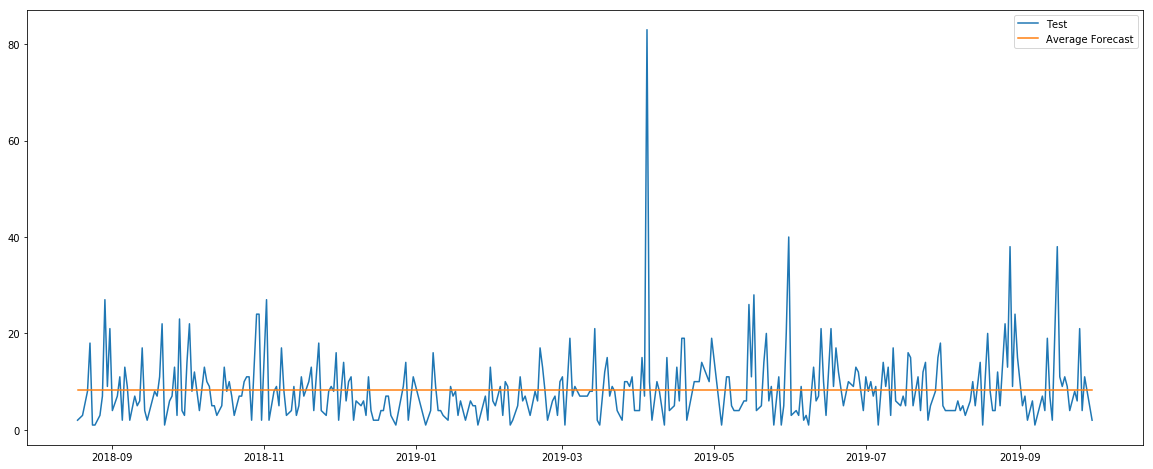

rms:7.503700979936133
mape:107.77432558446101
MAPE by week: 38.034


In [222]:
y_prediction = test.copy()
y_test=test.sold_qty
y_prediction["prediction"] = train['sold_qty'].mean()
plt.figure(figsize=(20,8))
#plt.plot(train['sold_qty'], label='Train')
plt.plot(test['sold_qty'], label='Test')
plt.plot(y_prediction['prediction'], label='Average Forecast')
plt.legend(loc='best')
plt.show()

rms = sqrt(mean_squared_error(y_test, y_prediction.prediction))
mape = mean_absolute_percentage_error(y_test, y_prediction.prediction)
mape_week = week_mean_absolute_percentage_error(y_test, y_prediction.prediction)
print("rms:"+str(rms))
print("mape:"+str(mape))
print('MAPE by week: %.3f' % mape_week )

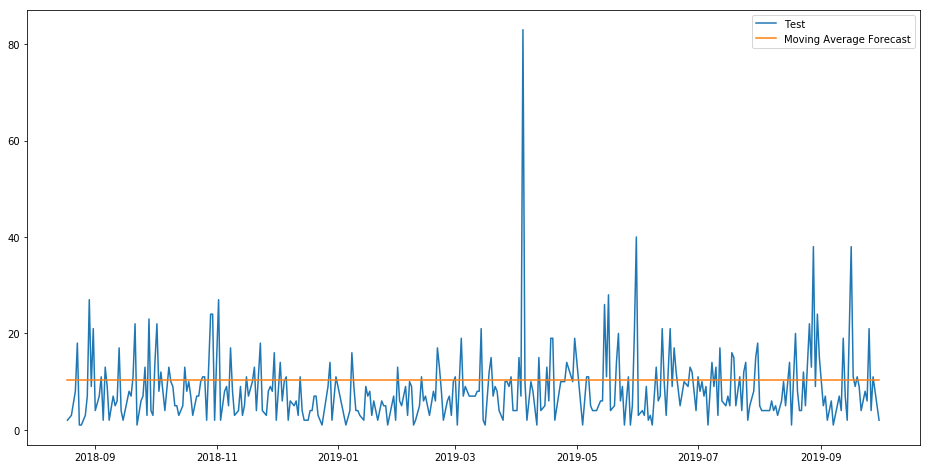

rms:7.683100075735165
mape:143.39225953938822
MAPE by week: 56.596


In [223]:
y_prediction = test.copy()
y_test=test.sold_qty
y_prediction["prediction"] = train['sold_qty'].rolling(60).mean().iloc[-1]
plt.figure(figsize=(16,8))
#plt.plot(train['sold_qty'], label='Train')
plt.plot(test['sold_qty'], label='Test')
plt.plot(y_prediction['prediction'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

rms = sqrt(mean_squared_error(y_test, y_prediction.prediction))
mape = mean_absolute_percentage_error(y_test, y_prediction.prediction)
mape_week = week_mean_absolute_percentage_error(y_test, y_prediction.prediction)
print("rms:"+str(rms))
print("mape:"+str(mape))
print('MAPE by week: %.3f' % mape_week )

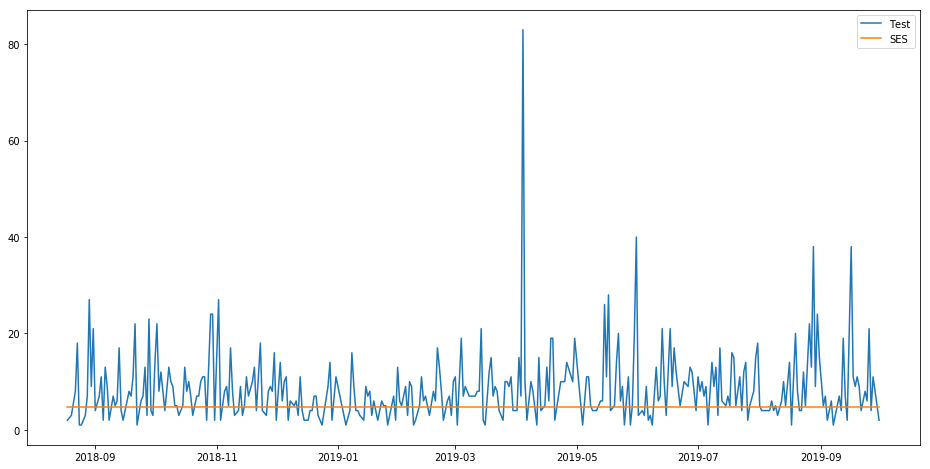

rms:8.41136214124909
mape:68.4080982929517
MAPE by week: 43.452


In [224]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
y_prediction = test.copy()
y_test=test.sold_qty
fit2 = SimpleExpSmoothing(np.asarray(train['sold_qty'])).fit(smoothing_level=0.6,optimized=False)
y_prediction["prediction"] = fit2.forecast(len(test))
plt.figure(figsize=(16,8))
#plt.plot(train['sold_qty'], label='Train')
plt.plot(test['sold_qty'], label='Test')
plt.plot(y_prediction['prediction'], label='SES')
plt.legend(loc='best')
plt.show()
rms = sqrt(mean_squared_error(y_test, y_prediction.prediction))
mape = mean_absolute_percentage_error(y_test, y_prediction.prediction)
mape_week = week_mean_absolute_percentage_error(y_test, y_prediction.prediction)
print("rms:"+str(rms))
print("mape:"+str(mape))
print('MAPE by week: %.3f' % mape_week )

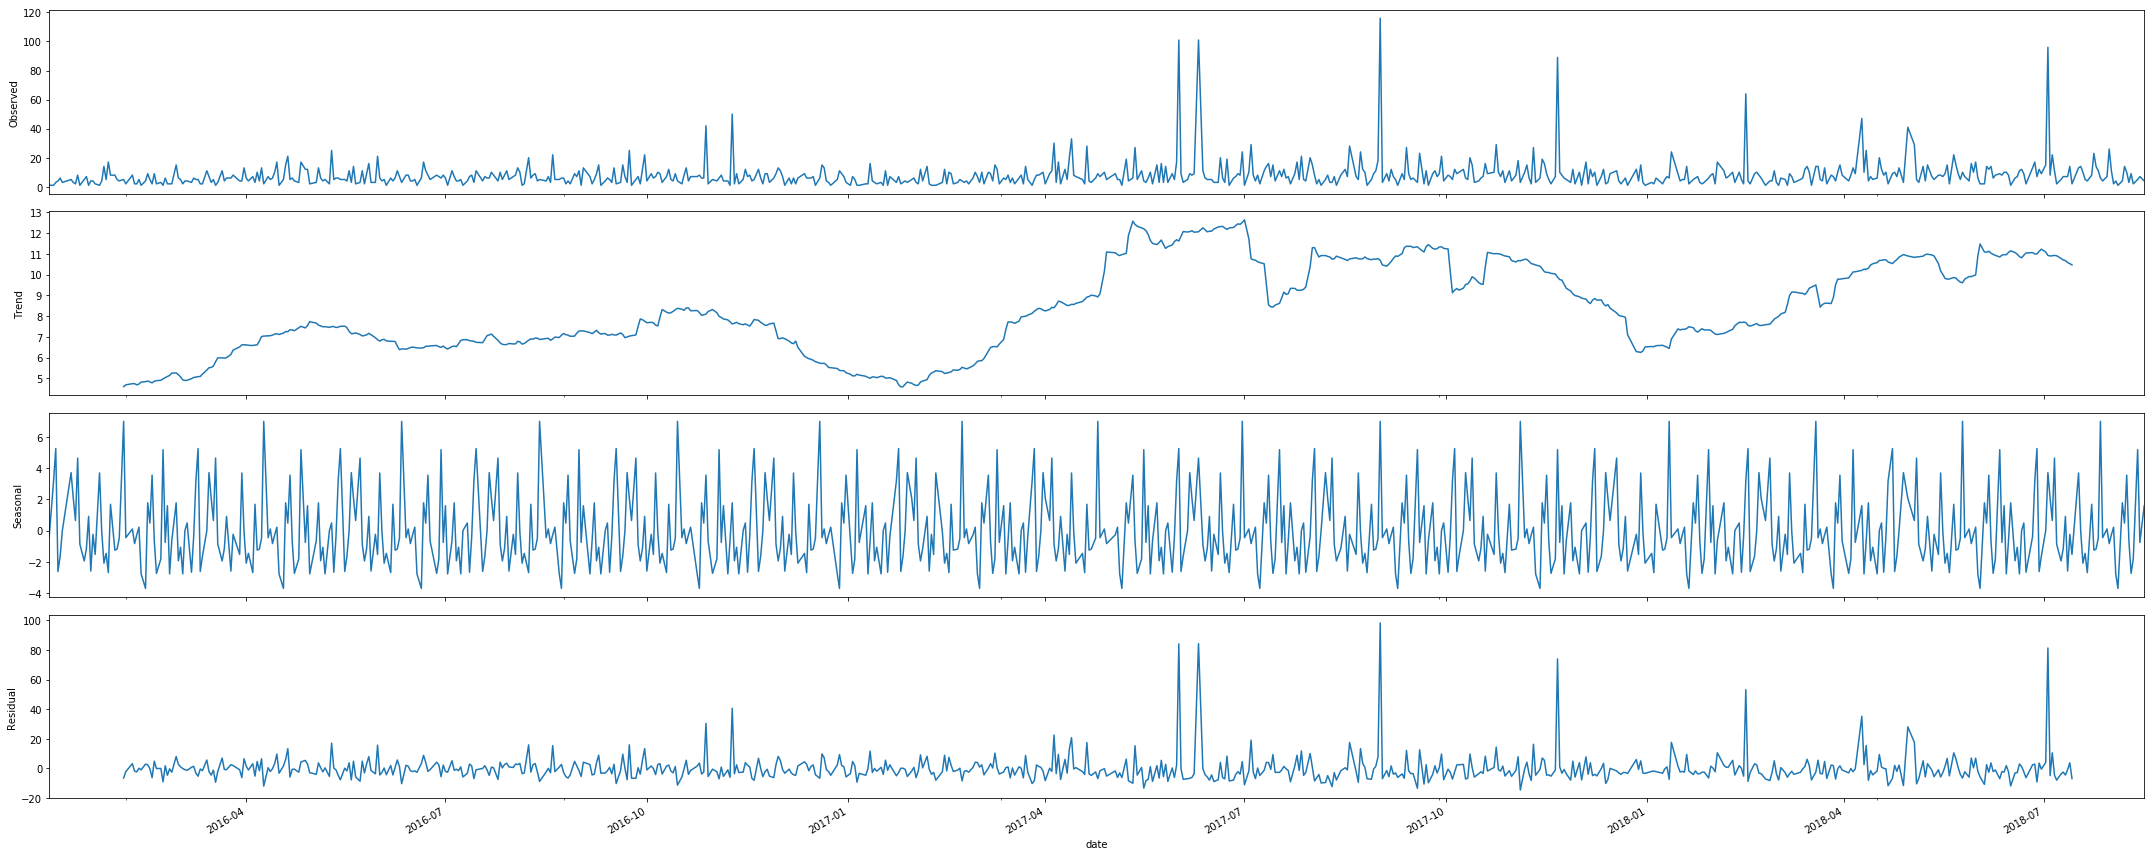

In [225]:
import statsmodels.api as sm
sm.tsa.seasonal_decompose(train.sold_qty, freq=52).plot()
result = sm.tsa.stattools.adfuller(train.sold_qty)
plt.show()

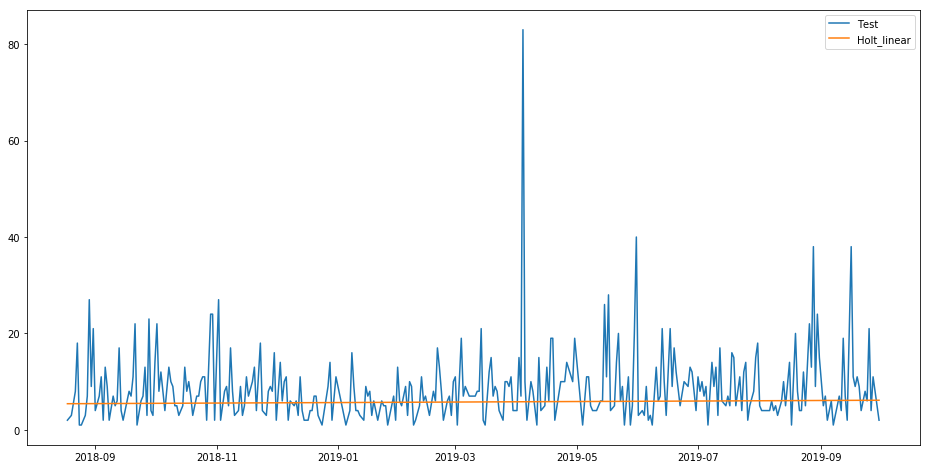

rms:8.011892800111344
mape:76.59873127828598
MAPE by week: 37.767


In [229]:
y_prediction = test.copy()
y_test=test.sold_qty
fit1 = Holt(np.asarray(train['sold_qty'])).fit(smoothing_level = 0.3,smoothing_slope = 0.001)
y_prediction["prediction"] = fit1.forecast(len(test))

plt.figure(figsize=(16,8))
#plt.plot(train['sold_qty'], label='Train')
plt.plot(test['sold_qty'], label='Test')
plt.plot(y_prediction['prediction'], label='Holt_linear')
plt.legend(loc='best')
plt.show()
rms = sqrt(mean_squared_error(y_test, y_prediction.prediction))
mape = mean_absolute_percentage_error(y_test, y_prediction.prediction)
mape_week = week_mean_absolute_percentage_error(y_test, y_prediction.prediction)
print("rms:"+str(rms))
print("mape:"+str(mape))
print('MAPE by week: %.3f' % mape_week )

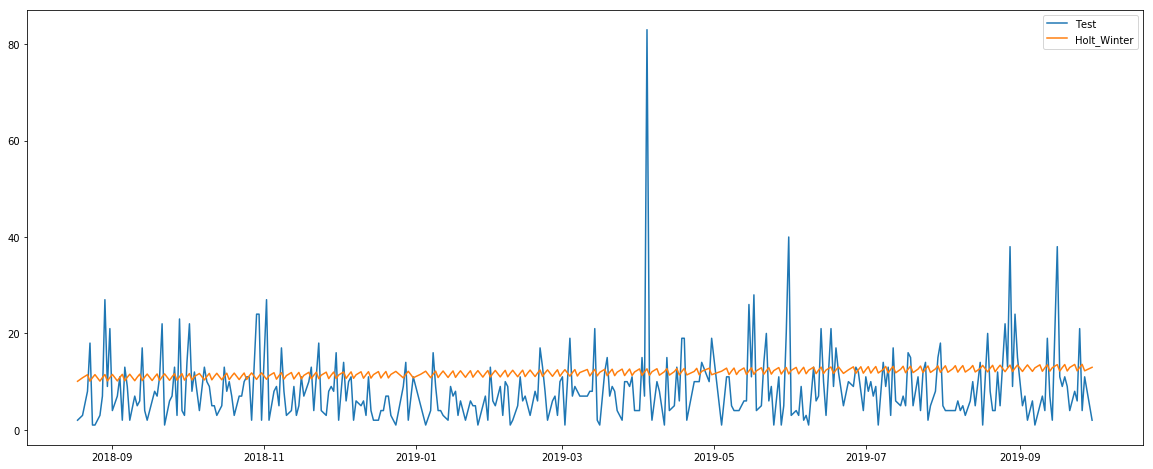

rms:8.137927932036282
mape:172.11299208111276
MAPE by week: 73.602


In [244]:
y_prediction = test.copy()
y_test=test.sold_qty
fit1 = ExponentialSmoothing(np.asarray(train['sold_qty']) ,seasonal_periods=3 ,trend='add', seasonal='add').fit()
y_prediction['prediction'] = fit1.forecast(len(test))
plt.figure(figsize=(20,8))
#plt.plot( train['sold_qty'], label='Train')
plt.plot(test['sold_qty'], label='Test')
plt.plot(y_prediction['prediction'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()
rms = sqrt(mean_squared_error(y_test, y_prediction.prediction))
mape = mean_absolute_percentage_error(y_test, y_prediction.prediction)
mape_week = week_mean_absolute_percentage_error(y_test, y_prediction.prediction)
print("rms:"+str(rms))
print("mape:"+str(mape))
print('MAPE by week: %.3f' % mape_week )

C:\Users\mbutkovic\Documents\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\mbutkovic\Documents\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


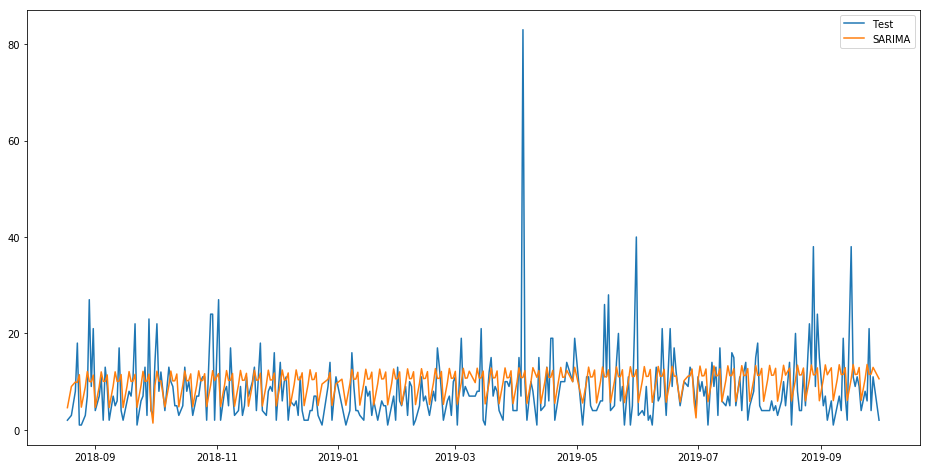

rms:7.255200015998804
mape:111.6825410725128
MAPE by week: 49.896


In [262]:
y_prediction = test.copy()
y_test=test.sold_qty
fit1 = sm.tsa.statespace.SARIMAX(train.asfreq(freq='D', fill_value=0).sold_qty, order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit()
y_prediction['prediction'] = fit1.predict(start=train.index.max()-pd.DateOffset(1), end=test.index.max(), dynamic=True, full_results=True)
plt.figure(figsize=(16,8))
#plt.plot( train['sold_qty'], label='Train')
plt.plot(test['sold_qty'], label='Test')
plt.plot(y_prediction['prediction'], label='SARIMA')
plt.legend(loc='best')
plt.show()
rms = sqrt(mean_squared_error(y_test, y_prediction.prediction))
mape = mean_absolute_percentage_error(y_test, y_prediction.prediction)
mape_week = week_mean_absolute_percentage_error(y_test, y_prediction.prediction)
print("rms:"+str(rms))
print("mape:"+str(mape))
print('MAPE by week: %.3f' % mape_week )

C:\Users\mbutkovic\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\mbutkovic\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 1, 5); AIC=5707.035, BIC=5744.206, Fit time=2.197 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 5); AIC=6223.196, BIC=6232.489, Fit time=0.024 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 5); AIC=6013.335, BIC=6031.921, Fit time=0.256 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 5); AIC=5701.881, BIC=5720.467, Fit time=0.881 seconds
Near non-invertible roots for order (0, 1, 1)(0, 0, 1, 5); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 5); AIC=6221.197, BIC=6225.843, Fit time=0.019 seconds


C:\Users\mbutkovic\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\mbutkovic\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\mbutkovic\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 1, 5); AIC=5704.849, BIC=5737.373, Fit time=1.914 seconds
Near non-invertible roots for order (2, 1, 2)(0, 0, 1, 5); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)


C:\Users\mbutkovic\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\mbutkovic\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 0, 5); AIC=5704.914, BIC=5737.438, Fit time=1.605 seconds
Near non-invertible roots for order (2, 1, 2)(1, 0, 0, 5); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)


C:\Users\mbutkovic\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\mbutkovic\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Fit ARIMA: order=(2, 1, 2) seasonal_order=(2, 0, 1, 5); AIC=5708.987, BIC=5750.805, Fit time=3.401 seconds
Near non-invertible roots for order (2, 1, 2)(2, 0, 1, 5); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)


C:\Users\mbutkovic\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\mbutkovic\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 2, 5); AIC=5708.804, BIC=5750.621, Fit time=3.500 seconds
Near non-invertible roots for order (2, 1, 2)(1, 0, 2, 5); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)


C:\Users\mbutkovic\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\mbutkovic\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 5); AIC=5702.831, BIC=5730.710, Fit time=1.004 seconds
Near non-invertible roots for order (2, 1, 2)(0, 0, 0, 5); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)


C:\Users\mbutkovic\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\mbutkovic\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 2, 5); AIC=5706.934, BIC=5744.105, Fit time=3.321 seconds
Near non-invertible roots for order (2, 1, 2)(0, 0, 2, 5); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)


C:\Users\mbutkovic\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\mbutkovic\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Fit ARIMA: order=(2, 1, 2) seasonal_order=(2, 0, 0, 5); AIC=5706.843, BIC=5744.014, Fit time=3.349 seconds
Near non-invertible roots for order (2, 1, 2)(2, 0, 0, 5); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)


C:\Users\mbutkovic\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\mbutkovic\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Fit ARIMA: order=(2, 1, 2) seasonal_order=(2, 0, 2, 5); AIC=5710.927, BIC=5757.391, Fit time=3.898 seconds
Near non-invertible roots for order (2, 1, 2)(2, 0, 2, 5); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 0, 1, 5); AIC=5708.088, BIC=5740.613, Fit time=1.603 seconds
Near non-invertible roots for order (1, 1, 2)(1, 0, 1, 5); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)


C:\Users\mbutkovic\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 1) seasonal_order=(1, 0, 1, 5); AIC=5707.642, BIC=5740.167, Fit time=1.722 seconds
Near non-invertible roots for order (2, 1, 1)(1, 0, 1, 5); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)


C:\Users\mbutkovic\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 2) seasonal_order=(1, 0, 1, 5); AIC=5708.703, BIC=5750.521, Fit time=2.453 seconds
Near non-invertible roots for order (3, 1, 2)(1, 0, 1, 5); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)


C:\Users\mbutkovic\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(1, 0, 1, 5); AIC=5710.326, BIC=5752.144, Fit time=2.782 seconds
Near non-invertible roots for order (2, 1, 3)(1, 0, 1, 5); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 1, 5); AIC=5705.730, BIC=5733.608, Fit time=1.944 seconds
Near non-invertible roots for order (1, 1, 1)(1, 0, 1, 5); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(1, 1, 3) seasonal_order=(1, 0, 1, 5); AIC=5706.808, BIC=5743.979, Fit time=1.751 seconds
Near non-invertible roots for order (1, 1, 3)(1, 0, 1, 5); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: order=(3, 1, 1) seasonal_order=(1, 0, 1, 5); AIC=5709.964, BIC=5747.135, Fit time=1.510 seconds


C:\Users\mbutkovic\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 3) seasonal_order=(1, 0, 1, 5); AIC=5710.059, BIC=5756.523, Fit time=3.011 seconds
Near non-invertible roots for order (3, 1, 3)(1, 0, 1, 5); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 42.184 seconds


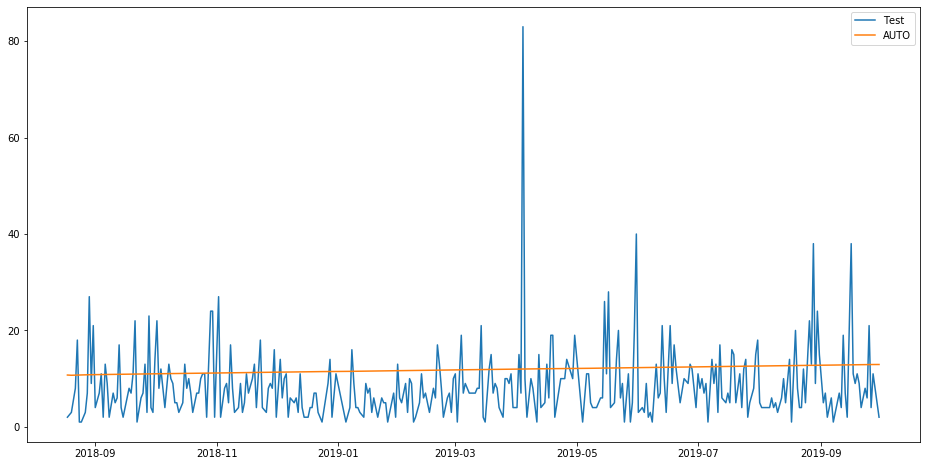

rms:8.118715094155945
mape:170.35926188942332
MAPE by week: 74.058


In [11]:
import pmdarima as pm

y_prediction = test.copy()
y_test=test.sold_qty
model = pm.auto_arima(train, trace=1, seasonal=True, m=5)
y_prediction['prediction'] = model.predict(test.shape[0])  # predict N steps into the future

plt.figure(figsize=(16,8))
#plt.plot( train['sold_qty'], label='Train')
plt.plot(test['sold_qty'], label='Test')
plt.plot(y_prediction['prediction'], label='AUTO')
plt.legend(loc='best')
plt.show()
rms = sqrt(mean_squared_error(y_test, y_prediction.prediction))
mape = mean_absolute_percentage_error(y_test, y_prediction.prediction)
mape_week = week_mean_absolute_percentage_error(y_test, y_prediction.prediction)
print("rms:"+str(rms))
print("mape:"+str(mape))
print('MAPE by week: %.3f' % mape_week )

[17:33:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:11.9303	validation_1-rmse:10.4522
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:11.4516	validation_1-rmse:9.91389
[2]	validation_0-rmse:11.0217	validation_1-rmse:9.38493
[3]	validation_0-rmse:10.6487	validation_1-rmse:8.99865
[4]	validation_0-rmse:10.3208	validation_1-rmse:8.65178
[5]	validation_0-rmse:10.0494	validation_1-rmse:8.39024
[6]	validation_0-rmse:9.82404	validation_1-rmse:8.14642
[7]	validation_0-rmse:9.61407	validation_1-rmse:7.94948
[8]	validation_0-rmse:9.45232	validation_1-rmse:7.79813
[9]	validation_0-rmse:9.29944	validation_1-rmse:7.67464
[10]	validation_0-rmse:9.1754	validation_1-rmse:7.54857
[11]	validation_0-rmse:9.05539	validation_1-rmse:7.46404
[12]

C:\Users\mbutkovic\Documents\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\mbutkovic\Documents\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[63]	validation_0-rmse:7.51316	validation_1-rmse:7.62532
[64]	validation_0-rmse:7.49915	validation_1-rmse:7.66336
[65]	validation_0-rmse:7.49196	validation_1-rmse:7.65821
[66]	validation_0-rmse:7.48907	validation_1-rmse:7.66322
[67]	validation_0-rmse:7.48651	validation_1-rmse:7.66866
[68]	validation_0-rmse:7.47392	validation_1-rmse:7.70664
[69]	validation_0-rmse:7.42604	validation_1-rmse:7.71427
[70]	validation_0-rmse:7.36581	validation_1-rmse:7.72807
[71]	validation_0-rmse:7.36062	validation_1-rmse:7.72079
[72]	validation_0-rmse:7.34809	validation_1-rmse:7.73071
[73]	validation_0-rmse:7.3392	validation_1-rmse:7.73695
[74]	validation_0-rmse:7.31036	validation_1-rmse:7.73963
Stopping. Best iteration:
[24]	validation_0-rmse:8.28028	validation_1-rmse:7.17481



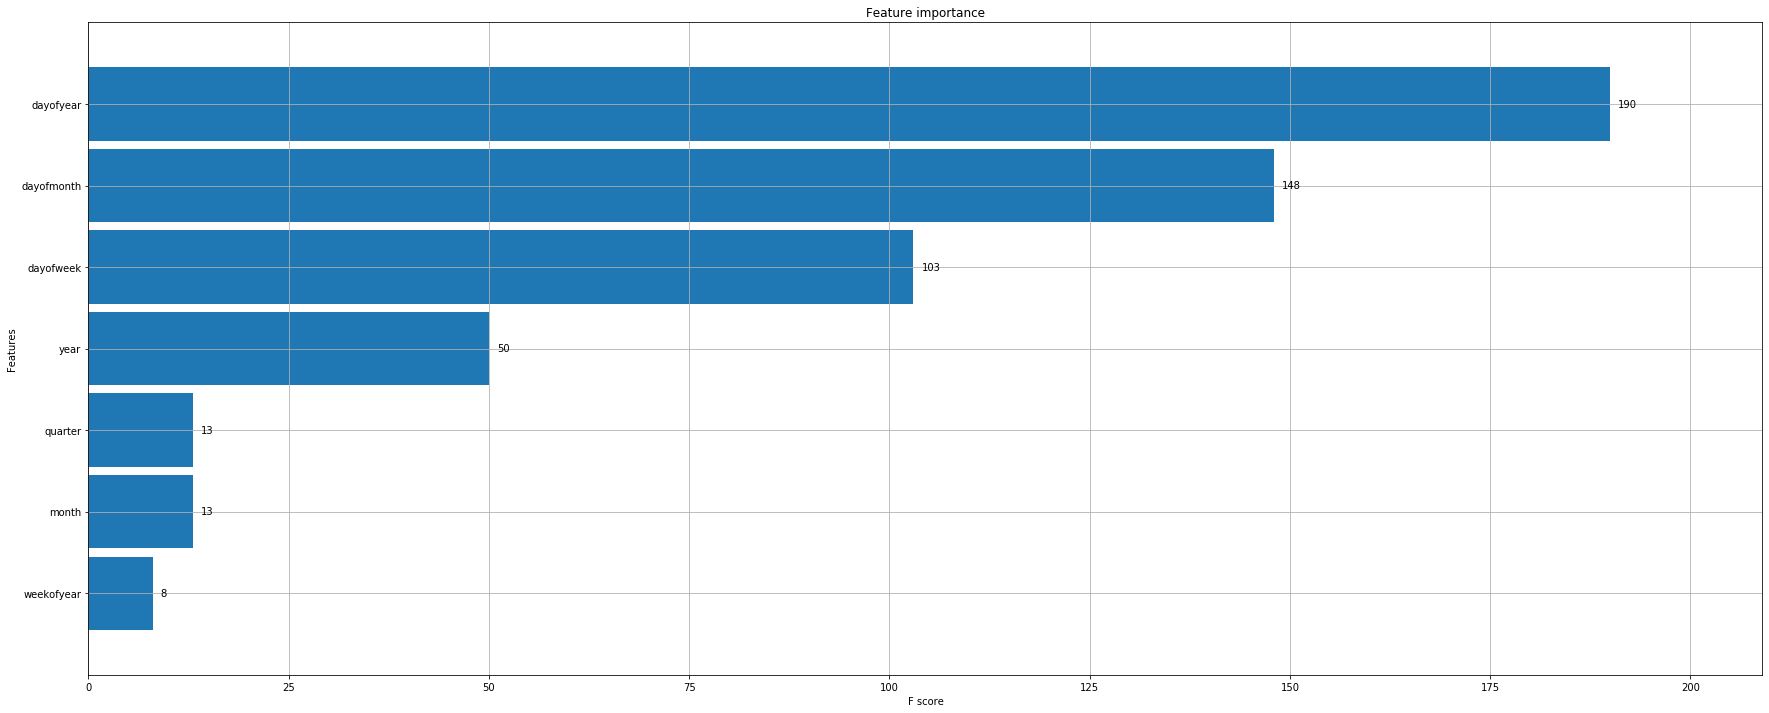

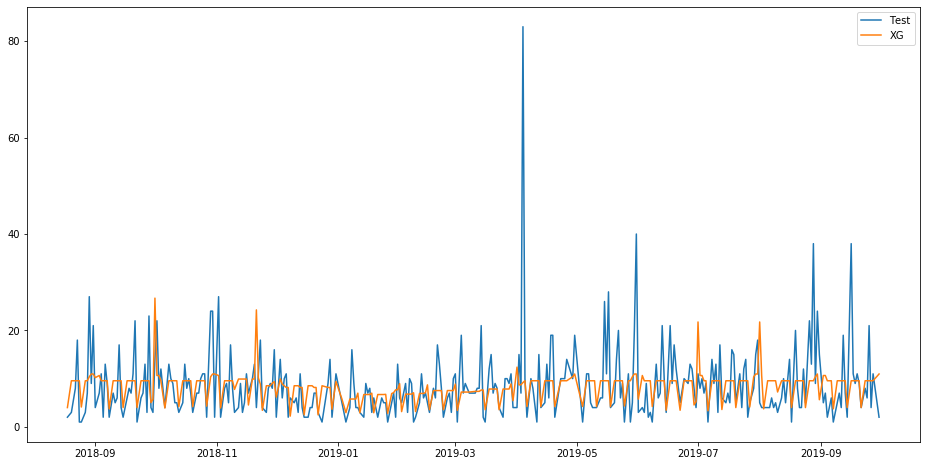

rms:7.174813466586085
mape:83.7869568973079
MAPE by week: 33.530


In [13]:
import numpy as np
import xgboost as xgb

def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

y_prediction = test.copy()
y_test=test.sold_qty

X_train, y_train = create_features(train, label='sold_qty')
X_test, y_test = create_features(y_prediction, label='sold_qty')

reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=True) # Change verbose to True if you want to see it train

from xgboost import plot_importance, plot_tree
_ = plot_importance(reg, height=0.9)

y_prediction['prediction'] = reg.predict(X_test)

plt.figure(figsize=(16,8))
#plt.plot( train['sold_qty'], label='Train')
plt.plot(test['sold_qty'], label='Test')
plt.plot(y_prediction['prediction'], label='XG')
plt.legend(loc='best')
plt.show()
rms = sqrt(mean_squared_error(y_test, y_prediction.prediction))
mape = mean_absolute_percentage_error(y_test, y_prediction.prediction)
mape_week = week_mean_absolute_percentage_error(y_test, y_prediction.prediction)
print("rms:"+str(rms))
print("mape:"+str(mape))
print('MAPE by week: %.3f' % mape_week )

Wall time: 0 ns


C:\Users\mbutkovic\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\mbutkovic\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\mbutkovic\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\mbutkovic\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: 

C:\Users\mbutkovic\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\mbutkovic\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\mbutkovic\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\mbutkovic\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequenc

C:\Users\mbutkovic\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\mbutkovic\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\mbutkovic\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\mbutkovic\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequenc

C:\Users\mbutkovic\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\mbutkovic\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\mbutkovic\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\mbutkovic\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

C:\Users\mbutkovic\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\mbutkovic\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\mbutkovic\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                      SARIMAX Results                                       
Dep. Variable:                             sold_qty   No. Observations:                  771
Model:             SARIMAX(2, 1, 3)x(0, 1, [1], 24)   Log Likelihood               -2799.606
Date:                              Sun, 02 Feb 2020   AIC                           5613.212
Time:                                      17:56:38   BIC                           5645.515
Sample:                                           0   HQIC                          5625.662
                                              - 771                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0527      0.009   -115.265      0.000      -1.071      -1.035
ar.L2         -0.98

C:\Users\mbutkovic\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\mbutkovic\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


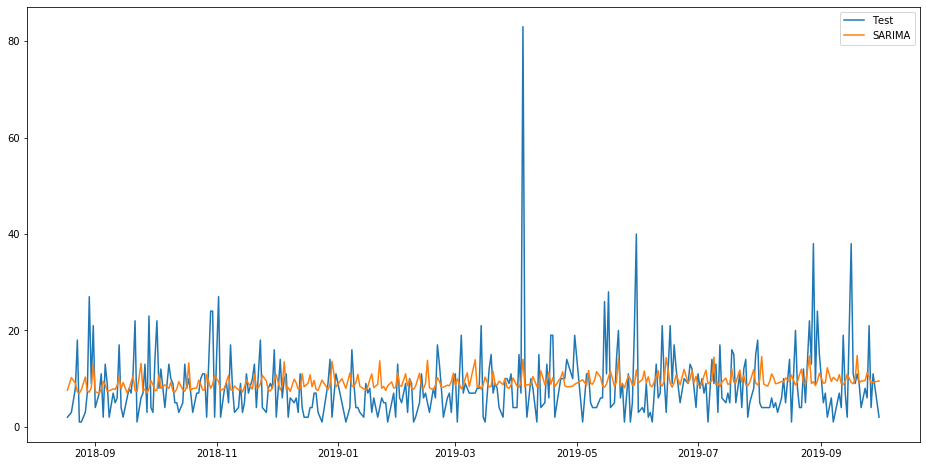

rms:7.511432000190699
mape:124.2833412688346
MAPE by week: 43.615


In [14]:
from itertools import product  
from tqdm import tqdm_notebook
import sys
from statsmodels.tsa.statespace.sarimax import SARIMAX

#import statsmodels.api as sm
#sm.tsa.seasonal_decompose(ts.sold_qty, freq=52).plot()
#result = sm.tsa.stattools.adfuller(ts.sold_qty)
#plt.show()

ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 24 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters) 

def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=SARIMAX(train.sold_qty, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
            aic = model.aic
        # saving best model, AIC and parameters
            if aic < best_aic:
                best_model = model
                best_aic = aic
                best_param = param
            results.append([param, model.aic])
        #print(model)
        except:
         #   print(sys.exc_info()[0])
            continue
        

    result_table = pd.DataFrame(results)
    #print(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

%time
result_table = optimizeSARIMA(parameters_list, d, D, s)
p, q, P, Q = result_table.parameters[0]

best_model=SARIMAX(train.sold_qty, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

y_prediction = test.copy()
y_test=test.sold_qty
fit1 = SARIMAX(train.asfreq(freq='D', fill_value=0).sold_qty, order=(p, d, q),seasonal_order=(P, D, Q, s)).fit()
y_prediction['prediction'] = fit1.predict(start=train.index.max()-pd.DateOffset(1), end=test.index.max(), dynamic=True, full_results=True)
plt.figure(figsize=(16,8))
#plt.plot( train['sold_qty'], label='Train')
plt.plot(test['sold_qty'], label='Test')
plt.plot(y_prediction['prediction'], label='SARIMA')
plt.legend(loc='best')
plt.show()
rms = sqrt(mean_squared_error(y_test, y_prediction.prediction))
mape = mean_absolute_percentage_error(y_test, y_prediction.prediction)
mape_week = week_mean_absolute_percentage_error(y_test, y_prediction.prediction)
print("rms:"+str(rms))
print("mape:"+str(mape))
print('MAPE by week: %.3f' % mape_week )

In [43]:
train_fb = train.rename(columns={'sold_qty': 'y', 'date':'ds'})
train_fb.index.names = ['ds']
train_fb = train_fb.reset_index()

In [51]:
test_fb = test.rename(columns={'sold_qty': 'y', 'date':'ds'})
test_fb.index.names = ['ds']
test_fb = test_fb.reset_index()

In [47]:
train_fb['y'] = np.log(train_fb['y']) 

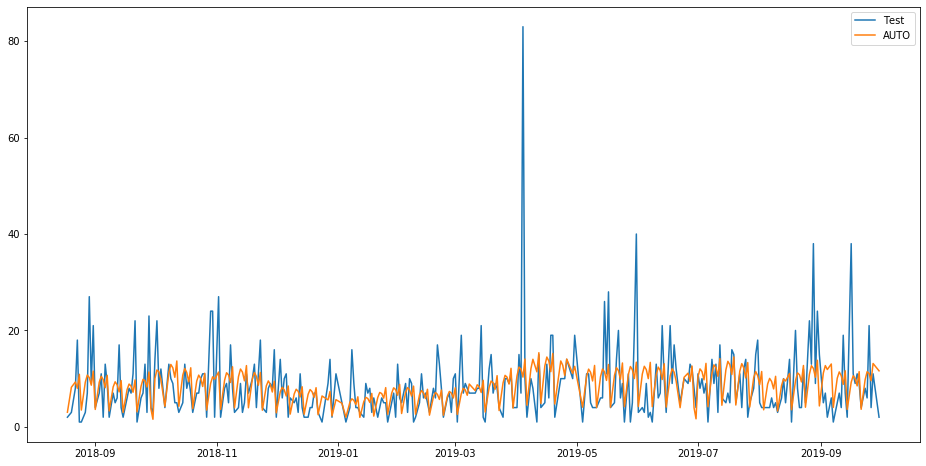

rms:6.996855622672672
mape:84.4665154165107
MAPE by week: 36.520


In [54]:
%matplotlib inline
import os  
import pandas as pd  
import numpy as np  
from fbprophet import Prophet

%matplotlib inline
import os  
import pandas as pd  
import numpy as np  
from fbprophet import Prophet
from math import sqrt
from sklearn.metrics import mean_squared_error

y_prediction = test.copy()
y_test=test.sold_qty

m = Prophet(daily_seasonality=True)  
m.fit(train_fb)

forecast = m.predict(test_fb)
y_prediction['prediction'] = forecast[['ds','yhat']].set_index('ds')

y_prediction = np.exp(y_prediction)
plt.figure(figsize=(16,8))
#plt.plot( train['sold_qty'], label='Train')
plt.plot(test['sold_qty'], label='Test')
plt.plot(y_prediction['prediction'], label='AUTO')
plt.legend(loc='best')
plt.show()

rms = sqrt(mean_squared_error(y_test, y_prediction.prediction))
mape = mean_absolute_percentage_error(y_test, y_prediction.prediction)
mape_week = week_mean_absolute_percentage_error(y_test, y_prediction.prediction)
print("rms:"+str(rms))
print("mape:"+str(mape))
print('MAPE by week: %.3f' % mape_week )